<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/MR_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel


In [2]:
import nibabel as nib
import os
import imageio
import numpy as np


In [3]:
%tensorflow_version 1.x 
import tensorflow as tf

from tensorflow import keras
from scipy import ndimage, misc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

PATCH_SIZE = 32

TensorFlow 1.x selected.


In [4]:
def make_png(in_file, out_dir, cnt):
    Thick = ''
    if '1mm' in in_file:
        Thick = '1m'
    if '3mm' in in_file:
        Thick = '3m'
    elif '5mm' in in_file:
        Thick = '5m'
    
    Noise = ''
    if 'pn0' in in_file:
        Noise = '0n'
    if 'pn1' in in_file:
        Noise = '1n'
    if 'pn3' in in_file:
        Noise = '3n'
    elif 'pn5' in in_file:
        Noise = '5n'
    elif 'pn7' in in_file:
        Noise = '7n'
    Field = ''
    if 'rf20' in in_file:
        Field = '2f'
    if 'rf0' in in_file:
        Field = '0f'

    if Thick == '' or Noise == '' or Field == '':
        print (f"Error coding {in_file}")
        return cnt

    fh = nib.load(in_file)
    data = fh.get_data()
    top = np.percentile(data, 95)
    bot = np.percentile(data, 5)
    data = np.clip(data, a_min=bot, a_max=top)
    data = data - bot
    data = data * 255.0 / (top-bot)
    data = data.astype(np.uint8)
    (xd,yd,zd) = data.shape
    
    #print (f"XD-{xd}, YD-{yd}, ZD-{zd}")
    if 'pd' in in_file:
        outname='PD'
    elif 't2' in in_file:
        outname ='T2'
    else:
        outname = 'T1'

    if 'normal' in in_file:
        outname = outname + '-nl-'
    else:
        outname = outname + '-ms-'


    new_zd = (zd // PATCH_SIZE) * PATCH_SIZE
    new_yd = (yd // PATCH_SIZE) * PATCH_SIZE
    z_offset = (zd - new_zd) // 2
    y_offset = (yd - new_yd) // 2
    #print(f'{new_zd} - {new_yd}')
    # crop to central block that is multipel of PATCH_SIZE

    for x in range(xd):
#        print (f'Slice {z} of {zd}')
        img = data[x,y_offset:y_offset+new_yd,z_offset:z_offset+new_zd]
#        if z == 0:
#            print(f'Image shape: {img.shape}')
        for y in range(y_offset, new_yd, PATCH_SIZE):
            for z in range(z_offset, new_zd, PATCH_SIZE):
                img = data[x, y:y + PATCH_SIZE, z:z+PATCH_SIZE]
                fname = os.path.join(out_dir, outname + str(x) + '-' + str(y) + '-' + str(z) + '-' + Noise+'-'+Thick+Field + '.png')
                imageio.imwrite(fname, img)
                cnt = cnt + 1
    return cnt

In [5]:
G_PATH = "/content/drive/MyDrive/MR_Denoising_Images"
if os.path.exists(G_PATH):
    temp = os.listdir(G_PATH)
    # print (temp)
    file_list = []
    for f in temp:
        file_list.append(os.path.join(G_PATH, f))
else:
    file_list = os.listdir(".")


PNG_PATH = "./PNG"


!rm -rf "./PNG"
!mkdir "./PNG"

cnt = 0

for f in file_list:
    if '.gz' in f and 'MPRAGE' not in f:  # don't do the example image
        print (f'Working on {f}--{cnt} PNGs made so far')
        cnt = make_png(f, PNG_PATH, cnt)
print (f"Wrote {cnt} files.")

Working on /content/drive/MyDrive/MR_Denoising_Images/t2_ai_msles2_1mm_pn0_rf0.mnc.gz--0 PNGs made so far


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Working on /content/drive/MyDrive/MR_Denoising_Images/t1_ai_msles2_1mm_pn5_rf0.mnc.gz--5430 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/t1_ai_msles2_1mm_pn3_rf0.mnc.gz--10860 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/pd_ai_msles2_1mm_pn3_rf0.mnc.gz--16290 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/pd_ai_msles2_1mm_pn5_rf0.mnc.gz--21720 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/pd_ai_msles2_5mm_pn0_rf0.mnc.gz--27150 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/t2_ai_msles2_5mm_pn0_rf0.mnc.gz--28230 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/t1_ai_msles2_5mm_pn3_rf0.mnc.gz--29310 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/t1_ai_msles2_5mm_pn5_rf0.mnc.gz--30390 PNGs made so far
Working on /content/drive/MyDrive/MR_Denoising_Images/t1_ai_msles2_5mm_pn7_rf0.mnc.gz--31470 PNGs made so far
Working on 

In [6]:
# load training data, used to update CNN weights
# for each noise image find the matching no noise image 
# (there are more than 1 noise per no noise)
pngs = os.listdir(PNG_PATH)

no_noise_data = None
noise_data = None

z = 0
fails = 0
for f in os.listdir(PNG_PATH):
    if '0n' not in f and fails < 100: # work from the noise images
        # make the no noise filename and load it at same location
#        f2 = f.replace("5m", "1m").replace("3m", "1m").replace("2f", "0f")
        f2 = f.replace("5n", "0n").replace("3n", "0n").replace("1n", "0n").replace("7n", "0n")
        try:
            img = imageio.imread(os.path.join(PNG_PATH, f2))
            # print(img.shape)
            if z == 0:
                no_noise_data = np.asarray(img)
            else:
                no_noise_data = np.dstack((no_noise_data, img))

            img = imageio.imread(os.path.join(PNG_PATH, f))
    #            print(f'Image shape: {img.shape}')
            if z == 0:
                noise_data = np.asarray(img)
            else:
                noise_data = np.dstack((noise_data, img))

            if z % 1000 == 0:
                print (str(z))
            z = z + 1
        except:
            pass
            #print(f'Failure with noise file {f} and nonoise {f2}')
            #fails = fails + 1

print (f"{no_noise_data.shape} is before shape")



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
(32, 32, 97260) is before shape


In [7]:
print (noise_data.shape)
no = np.copy(no_noise_data)
noise =np.copy(noise_data)

(32, 32, 97260)


In [8]:
no_noise_data = np.copy(no)
noise_data =np.copy(noise)
print (no_noise_data.shape)

(32, 32, 97260)


In [9]:

# now reshape to 32x32 patches
(x,y,z) = noise_data.shape
sz = x * y * z
total_images = z
print (f'Had {z} images,({sz} bytes) but now have {total_images} pathces of size {PATCH_SIZE}')
print (f'new size is {total_images} x 32 x 32 = {total_images*PATCH_SIZE*PATCH_SIZE}')


Had 97260 images,(99594240 bytes) but now have 97260 pathces of size 32
new size is 97260 x 32 x 32 = 99594240


In [10]:
def imgshow(img):

  plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  plt.xticks([])
  plt.yticks([])

  return

32


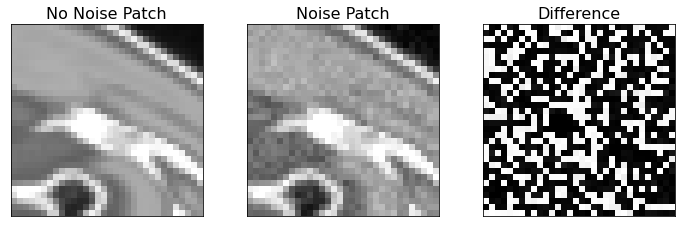

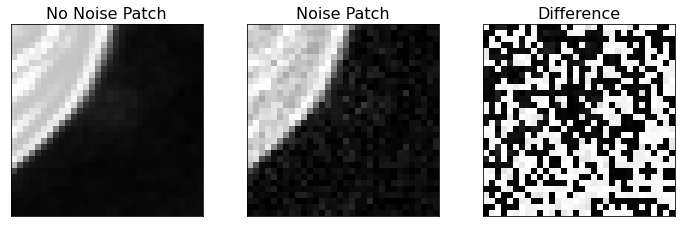

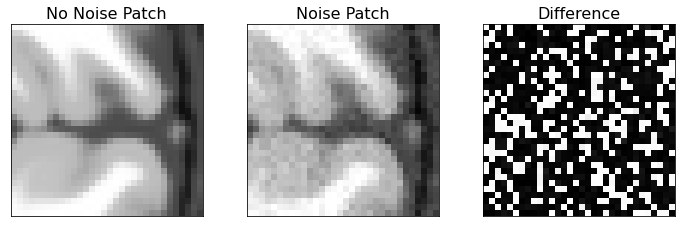

In [14]:
z = noise_data.shape[2]
print(z)
image_examples = [z//8, z//5, z//2, 3*z//4]

for row in range(3):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  plt.subplot(3, 3, 1+row*3)
  plt.title('No Noise Patch', fontsize=16)
  imgshow(no_noise_data[nexample, :, :])

  plt.subplot(3, 3, 2+row*3)
  plt.title('Noise Patch', fontsize=16)
  imgshow(noise_data[nexample, :, :])
  plt.subplot(3, 3, 3+row*3)

  plt.title('Difference', fontsize=16)
  imgshow(no_noise_data[nexample, :, :] - noise_data[nexample, :, :])

In [16]:

#no_noise_data = np.swapaxes(no_noise_data,0,2)
#noise_data = np.swapaxes(noise_data,0,2)
#print (f"{no_noise_data.shape} is after swap")


(97260, 32, 32) is after swap


In [ ]:
z = noise_data.shape[2]
print(z)
image_examples = [z//8, z//5, z//2, 3*z//4]

for row in range(3):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  plt.subplot(3, 3, 1+row*3)
  plt.title('No Noise Patch', fontsize=16)
  imgshow(no_noise_data[nexample,:, :,0])


In [17]:
print (noise_data.shape)
noise_data = np.expand_dims(noise_data, axis=3)
no_noise_data = np.expand_dims(no_noise_data, axis=3)
print (noise_data.shape)

(97260, 32, 32)
(97260, 32, 32, 1)


32


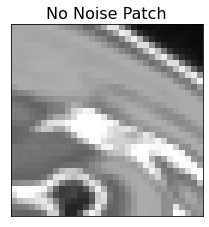

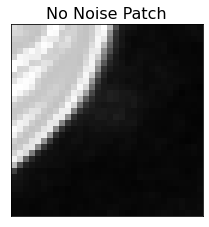

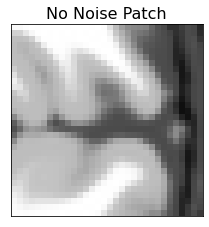

In [18]:
z = noise_data.shape[2]
print(z)
image_examples = [z//8, z//5, z//2, 3*z//4]

for row in range(3):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  plt.subplot(3, 3, 1+row*3)
  plt.title('No Noise Patch', fontsize=16)
  imgshow(no_noise_data[nexample, :, :,0])


32


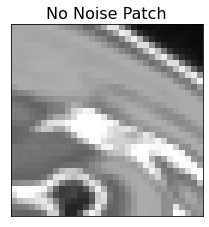

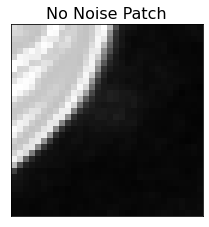

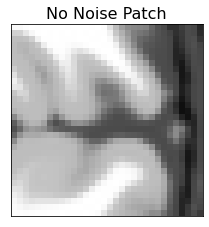

In [19]:
z = noise_data.shape[2]
print(z)
image_examples = [z//8, z//5, z//2, 3*z//4]

for row in range(3):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  plt.subplot(3, 3, 1+row*3)
  plt.title('No Noise Patch', fontsize=16)
  imgshow(no_noise_data[nexample, :, :,0])

In [20]:
# 70% train, 20% validation, 10% test
TRAIN_CNT = int(70 * total_images // 100)
VAL_CNT = int(20 * total_images // 100)
TEST_CNT = total_images - TRAIN_CNT - VAL_CNT

train_input = noise_data[0:TRAIN_CNT,:,:,:]
train_target = no_noise_data[0:TRAIN_CNT, :,:,:]

val_input = noise_data[TRAIN_CNT:TRAIN_CNT + VAL_CNT,:,:,:]
val_target = no_noise_data[TRAIN_CNT:TRAIN_CNT + VAL_CNT,:,:,:]

test_input = noise_data[TRAIN_CNT + VAL_CNT:,:,:,:]
test_target = no_noise_data[TRAIN_CNT + VAL_CNT:,:,:,:]

print(f'Train shape: {train_input.shape}')

Train shape: (68082, 32, 32, 1)


32


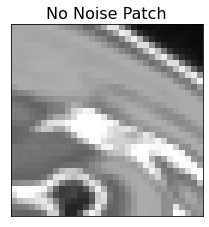

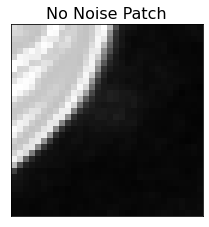

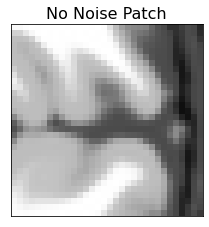

In [21]:
z = noise_data.shape[2]
print(z)
image_examples = [z//8, z//5, z//2, 3*z//4]

for row in range(3):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  plt.subplot(3, 3, 1+row*3)
  plt.title('No Noise Patch', fontsize=16)
  imgshow(no_noise_data[nexample, :, :,0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


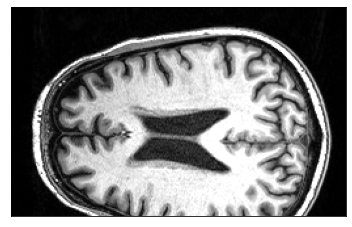

In [22]:

fh = nib.load(os.path.join(G_PATH, "MPRAGE.nii.gz"))
data = fh.get_data()
top = np.percentile(data, 95)
bot = np.percentile(data, 5)
data = np.clip(data, a_min=bot, a_max=top)
data = data - bot
data = data * 255.0 / (top-bot)
data = data.astype(np.uint8)
(xd,yd,zd) = data.shape

new_zd = (zd // PATCH_SIZE) * PATCH_SIZE
new_yd = (yd // PATCH_SIZE) * PATCH_SIZE
z_offset = (zd - new_zd) // 2
y_offset = (yd - new_yd) // 2
#print(f'{new_zd} - {new_yd}')
# crop to central block that is multipel of PATCH_SIZE

test_example = data[z_offset:z_offset+new_zd,y_offset:y_offset+new_yd,xd//2]
imgshow(test_example)


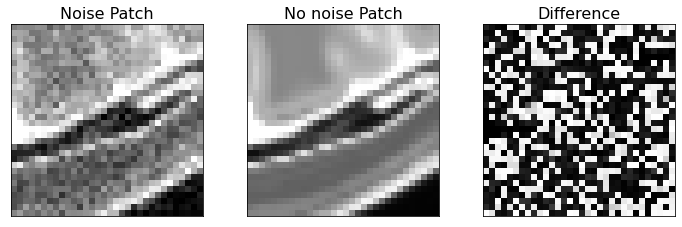

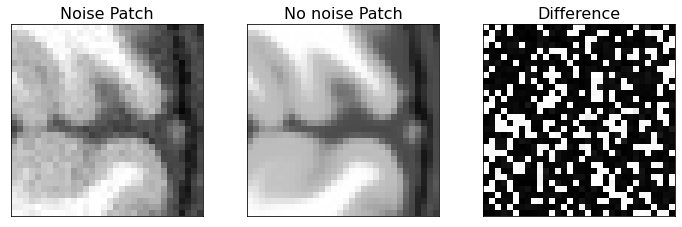

In [23]:
image_examples = [3, 16, 36]

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Noise Patch', fontsize=16)
  imgshow(train_input[nexample,:, :,0])

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('No noise Patch', fontsize=16)
  imgshow(train_target[nexample,:, :,0])
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  imgshow(train_target[nexample,:, :,0] - train_input[nexample,:, :,0])

In [24]:

# This specifies the number of convolutonal layers in the model
n_layers = 6 

# This specifies the number of convolutional filters in each convolutional layer
filters = 64 

# This specifies the size of the filter in each convolutional layer
kernel_size = (3, 3)

# This specifies the number of pixels the filter translates at each step
strides = (1, 1) 

# This specifies the non-linear function applied after each convolutionaly layer
activation = 'relu'


# This function builds the model according to the parameters set above
def build_model():

    # The input tensor image can have arbitrary spatial extent, but just
    # one channel for the grayscale CT images
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)
    
    # This loop adds each convolutional layer
    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)

    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model


denoising_model = build_model()
denoising_model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CT_denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_CT_images (InputLayer) [(None, None, None, 1)]   0         
_________________________________________________________________
normalization (Lambda)       (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
activation (Activation)      (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
________________________________________

In [28]:
# This sets the number of iterations through the training data
epochs = 15 

# This sets the number of images patches used to calcualte a single 
# parameter update.
batch_size = 128        

# This is a scaling factor that affects the magnitude of each optimization step
learning_rate = 0.0001  

# The optimizer manages how the parameters are updated from each gradient 
# calculation
optimizer = keras.optimizers.Adam(lr=learning_rate)

# As the training progresses, we'll monitor network output and performance
# metrics
progress_example = 2
buffer = 128
progress_ims = []

def train(loss_function, model):

    model.compile(optimizer=optimizer, loss=loss_function)

    # As the training progresses, we'll monitor network output and performance
    # metrics. Some related variables are initialized here
#    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):  

      # Evaluate model on reserved data
      val_loss = model.evaluate(val_input, val_target)
#      example_output = model.predict(test_example)
#      example_img = example_output[0, edge_buffer:-edge_buffer,
#                                edge_buffer:-edge_buffer, 0]
#      progress_ims.append(example_img)
      progress_val.append(val_loss)
    
      # Update model weights using training data
      istart = 0
      while istart < (len(train_input) - batch_size):
          x = train_input[istart:istart + batch_size]
          y = train_target[istart:istart + batch_size]
          model.train_on_batch(x=x, y=y)
          istart += batch_size

#    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val


# Now run the training fuction to obtain the trained model and performance at
# intermediate steps
denoising_model, progress_ims, progress_val = train(loss_function='mse', model=denoising_model)


19452/19452 [==============================] - 1s 67us/sample - loss: 23.4078
Training phase complete.


(9726, 32, 32, 1)


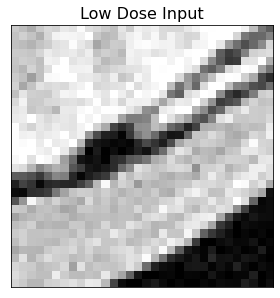

In [30]:
print(test_input.shape)
# Display an example input image, the denoised image, and the difference

CNNout = denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
imgshow(test_input[50, :, :, 0])
imgshow(CNNout[50, :, :, 0])
imgshow(test_input[50, :, :, 0]-CNNout[0, :, :, 0])


In [31]:

# Load the pre-trained VGG model from Keras
modelVGG = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, pooling=None)
modelVGG.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [32]:
# Here we specify which layers we will use to use to define the feature loss 
# Then we build a model that outputs the feature maps of these layers
feature_loss_layers = [
    'block3_conv3'
]

def get_VGG_features(feature_layers):

  # VGG expects normalized inputs, so we need to do some preprocessing to the CT
  # images first
  stack_layer = keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), name='stack')
  preproc_layer = keras.layers.Lambda(lambda x: (x + 1024.0)/1500., name='preprocess')
  clip_layer = keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0), name='clip')

  # Get VGG input and add preprocesing layers
  inputs = keras.layers.Input(shape=(None, None, 1))
  x = stack_layer(inputs)
  x = preproc_layer(x)
  x = clip_layer(x)

  # Re-connect subsequent layers, and add to output if layer was specified
  # for feature loss
  outputs = []
  for layer in modelVGG.layers[1:]:
    x = layer(x)
    if layer.name in feature_loss_layers:
      print('Adding layer {} to output'.format(layer.name))
      outputs.append(x)

  vgg_feature_model = keras.Model(inputs, outputs)
  return vgg_feature_model

feature_model = get_VGG_features(feature_loss_layers)
feature_model.trainable = False
feature_model.summary()


Adding layer block3_conv3 to output
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
stack (Lambda)               (None, None, None, 3)     0         
_________________________________________________________________
preprocess (Lambda)          (None, None, None, 3)     0         
_________________________________________________________________
clip (Lambda)                (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D

In [33]:

# Now we use the feature model to build a loss function that compares the VGG
# features between the CNN-denoised output (y_pred) and the routine-dose 
# reference (y_true).
def build_feature_loss(feature_extractor, mse_scale=0.01):
  
  def vgg_feature_loss(y_true, y_pred):

    # extract features and compute feature loss
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)

    if type(y_true_features) == list:
      feat_loss = 0.0
      for itrue, ipred in zip(y_true_features, y_pred_features):
        feat_loss += tf.reduce_mean(tf.square(itrue - ipred))
    else:
      feat_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))

    # also compute pixel-wise MSE loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    total_loss = feat_loss + (mse_scale * mse_loss)
      
    return total_loss

  return vgg_feature_loss

feature_loss = build_feature_loss(feature_model)

# Build a new denoising model (same architcture as before!), 
# and optimize the weights using feature loss
model_vggloss = build_model()
model_vggloss.summary()


Model: "CT_denoiser"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_CT_images (InputLayer) [(None, None, None, 1)]   0         
_________________________________________________________________
normalization (Lambda)       (None, None, None, 1)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
activation_5 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
activation_6 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    

In [34]:

model_vggloss, progress_ims, progress_val = train(loss_function=feature_loss, model=model_vggloss)



19452/19452 [==============================] - 3s 137us/sample - loss: 103.3846
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
19452/19452 [==============================] - 2s 117us/sample - loss: 0.3539
Training phase complete.


(9726, 32, 32, 1)


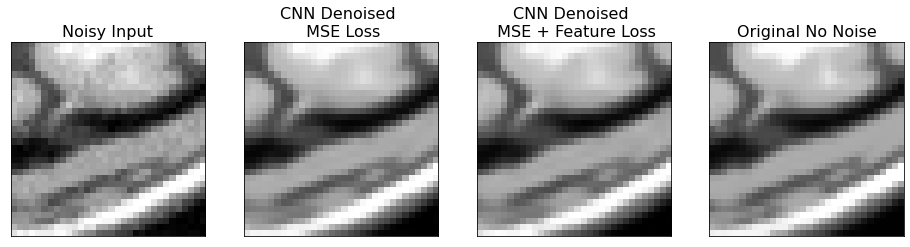

In [43]:
print(test_input.shape)
# Run models on reserved testing data
CNNout_mseloss = denoising_model.predict(test_input)
CNNout_vggloss = model_vggloss.predict(test_input)

# Plot for visual inspection of image quality
buffer = 32
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
slc = 124
plt.title('Noisy Input', fontsize=16)
imgshow(test_input[slc, :,:, 0])

plt.subplot(1, 4, 2)
plt.title('CNN Denoised \n MSE Loss', fontsize=16)
imgshow(CNNout_mseloss[slc, :,:, 0])

plt.subplot(1, 4, 3)
plt.title('CNN Denoised \n MSE + Feature Loss', fontsize=16)
imgshow(CNNout_vggloss[slc, :,:, 0])

plt.subplot(1, 4, 4)
plt.title('Original No Noise', fontsize=16)
imgshow(test_target[slc, :,:, 0])


